In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import atecml.data

from contextlib import contextmanager
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegressionCV
#build Models...
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE, ADASYN
import random

plt.style.use('ggplot')

In [13]:
def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='binary_error', model_type='gbdt',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=50, categorical_features=None):
    
    lgb_params = {
        'boosting_type': model_type,
        'objective': objective,
        'metric': metrics,
        'use_missing' : 'true',
        'learning_rate': 0.05,
        'num_leaves': 64,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 600,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 100,  # Number of bucketed bin for feature values
        'colsample_bytree': 0.9,
        'subsample': 0.85,  # Subsample ratio of the training instance.
        'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
        'min_child_weight': 0.05,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.01,  # L1 regularization term on weights
        'reg_lambda': 0.1,  # L2 regularization term on weights
        'nthread': 40,
        'verbose': -1,
    }

    lgb_params.update(params)
    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=verbose_eval, 
                     feval=feval)

    return bst1

def model_validation(train_df,val_df,predictors,target,params):
    categorical=[]
    for item in predictors:
        if (item in atecml.data.CATE_FEATURE_LIST):
            categorical.append(item)
            
    if (target == 'Normal'):
        params = {
            'scale_pos_weight' : 0.013,
        } 
    else:
        params = {
            'scale_pos_weight' : 76,
        }
    bst = lgb_modelfit_nocv(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        model_type='dart',
                        objective='binary', 
                        #metrics ='binary',
                        metrics={'auc'},
                        early_stopping_rounds=1000, 
                        verbose_eval=50, 
                        num_boost_round=10000, 
                        categorical_features=categorical
                        )
    y_predict = bst.predict(val_df[predictors])
    if (target == 'Normal'):
        y_predict = 1 - y_predict
    atec_Score,b,c=atecml.data.accuracy_validation(val_df['Fraud'],y_predict)
    return bst,atec_Score

In [4]:
train_df = atecml.data.load_train()

predictors = [x for x in train_df.columns if x not in atecml.data.NOT_FEATURE_COLUMNS]
DateFold={}

DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-12').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-13',end_date='2017-09-20').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-21',end_date='2017-09-28').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-09-29',end_date='2017-10-06').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-07',end_date='2017-10-14').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-11-24').index)

all_list = set(train_df.index) - set(DateFold[5])
len(all_list),len(DateFold[5])


(634284, 360447)

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.984546	valid's auc: 0.969758
[100]	train's auc: 0.986046	valid's auc: 0.97184
[150]	train's auc: 0.986718	valid's auc: 0.973149
[200]	train's auc: 0.98833	valid's auc: 0.974907
[250]	train's auc: 0.989489	valid's auc: 0.976111
[300]	train's auc: 0.990668	valid's auc: 0.977206
[350]	train's auc: 0.991269	valid's auc: 0.97784
[400]	train's auc: 0.992043	valid's auc: 0.978431
[450]	train's auc: 0.992733	valid's auc: 0.978881
[500]	train's auc: 0.993217	valid's auc: 0.979147
[550]	train's auc: 0.993665	valid's auc: 0.979217
[600]	train's auc: 0.993841	valid's auc: 0.979212
[650]	train's auc: 0.99416	valid's auc: 0.979419
[700]	train's auc: 0.99442	valid's auc: 0.979477
[750]	train's auc: 0.994642	valid's auc: 0.979357
[800]	train's auc: 0.994844	valid's auc: 0.979345
[850]	train's auc: 0.995081	valid's auc: 0.979644
[900]	train's auc: 0.995318	valid's auc: 0.979696
[950]	train'

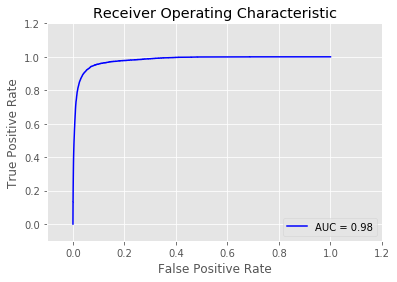

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.991834	valid's auc: 0.978264
[100]	train's auc: 0.993152	valid's auc: 0.98006
[150]	train's auc: 0.993391	valid's auc: 0.980953
[200]	train's auc: 0.993936	valid's auc: 0.981373
[250]	train's auc: 0.994614	valid's auc: 0.982357
[300]	train's auc: 0.995208	valid's auc: 0.983273
[350]	train's auc: 0.995512	valid's auc: 0.983268
[400]	train's auc: 0.995966	valid's auc: 0.983571
[450]	train's auc: 0.996421	valid's auc: 0.98426
[500]	train's auc: 0.996769	valid's auc: 0.98415
[550]	train's auc: 0.997038	valid's auc: 0.98419
[600]	train's auc: 0.997169	valid's auc: 0.984434
[650]	train's auc: 0.997383	valid's auc: 0.984604
[700]	train's auc: 0.997557	valid's auc: 0.984835
[750]	train's auc: 0.997727	valid's auc: 0.984934
[800]	train's auc: 0.997846	valid's auc: 0.984858
[850]	train's auc: 0.998022	valid's auc: 0.98492
[900]	train's auc: 0.998169	valid's auc: 0.984877
[950]	train'

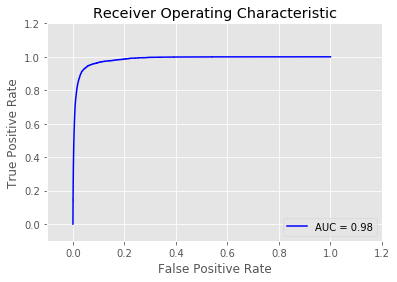

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.982699	valid's auc: 0.966402
[100]	train's auc: 0.98494	valid's auc: 0.969777
[150]	train's auc: 0.985738	valid's auc: 0.971338
[200]	train's auc: 0.987452	valid's auc: 0.972917
[250]	train's auc: 0.988543	valid's auc: 0.974174
[300]	train's auc: 0.989792	valid's auc: 0.975152
[350]	train's auc: 0.990487	valid's auc: 0.975616
[400]	train's auc: 0.991345	valid's auc: 0.976637
[450]	train's auc: 0.992088	valid's auc: 0.977352
[500]	train's auc: 0.992608	valid's auc: 0.977811
[550]	train's auc: 0.993022	valid's auc: 0.977884
[600]	train's auc: 0.993183	valid's auc: 0.977659
[650]	train's auc: 0.99349	valid's auc: 0.977873
[700]	train's auc: 0.993776	valid's auc: 0.977952
[750]	train's auc: 0.994058	valid's auc: 0.978015
[800]	train's auc: 0.994278	valid's auc: 0.978016
[850]	train's auc: 0.99453	valid's auc: 0.978136
[900]	train's auc: 0.994752	valid's auc: 0.978301
[950]	trai

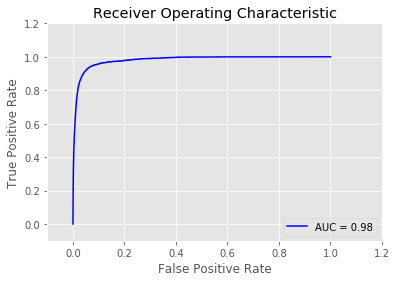

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.99126	valid's auc: 0.978631
[100]	train's auc: 0.992843	valid's auc: 0.980673
[150]	train's auc: 0.993217	valid's auc: 0.98118
[200]	train's auc: 0.993895	valid's auc: 0.981437
[250]	train's auc: 0.994506	valid's auc: 0.982426
[300]	train's auc: 0.995012	valid's auc: 0.982986
[350]	train's auc: 0.995336	valid's auc: 0.983126
[400]	train's auc: 0.995772	valid's auc: 0.983733
[450]	train's auc: 0.996186	valid's auc: 0.984101
[500]	train's auc: 0.996519	valid's auc: 0.984511
[550]	train's auc: 0.996803	valid's auc: 0.984676
[600]	train's auc: 0.996913	valid's auc: 0.984359
[650]	train's auc: 0.997141	valid's auc: 0.984708
[700]	train's auc: 0.997317	valid's auc: 0.984796
[750]	train's auc: 0.997486	valid's auc: 0.984913
[800]	train's auc: 0.997615	valid's auc: 0.984566
[850]	train's auc: 0.997787	valid's auc: 0.984517
[900]	train's auc: 0.997932	valid's auc: 0.984543
[950]	tra

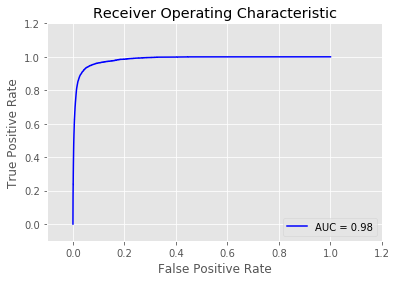

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.982076	valid's auc: 0.968949
[100]	train's auc: 0.984984	valid's auc: 0.971513
[150]	train's auc: 0.986038	valid's auc: 0.972698
[200]	train's auc: 0.987301	valid's auc: 0.973635
[250]	train's auc: 0.98847	valid's auc: 0.97424
[300]	train's auc: 0.989731	valid's auc: 0.975193
[350]	train's auc: 0.990408	valid's auc: 0.97568
[400]	train's auc: 0.991265	valid's auc: 0.976208
[450]	train's auc: 0.992061	valid's auc: 0.976994
[500]	train's auc: 0.992628	valid's auc: 0.977347
[550]	train's auc: 0.993058	valid's auc: 0.977776
[600]	train's auc: 0.993242	valid's auc: 0.977448
[650]	train's auc: 0.993574	valid's auc: 0.977664
[700]	train's auc: 0.993878	valid's auc: 0.977492
[750]	train's auc: 0.994146	valid's auc: 0.977341
[800]	train's auc: 0.994371	valid's auc: 0.977653
[850]	train's auc: 0.994576	valid's auc: 0.977976
[900]	train's auc: 0.994847	valid's auc: 0.978064
[950]	trai

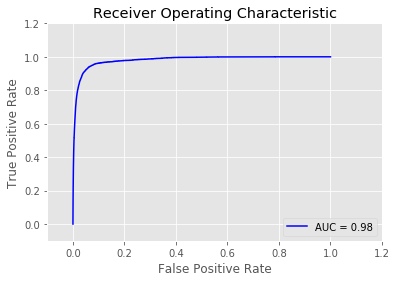

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.990877	valid's auc: 0.975371
[100]	train's auc: 0.992976	valid's auc: 0.97745
[150]	train's auc: 0.993505	valid's auc: 0.978703
[200]	train's auc: 0.994038	valid's auc: 0.978993
[250]	train's auc: 0.994601	valid's auc: 0.980024
[300]	train's auc: 0.995173	valid's auc: 0.981085
[350]	train's auc: 0.995497	valid's auc: 0.981336
[400]	train's auc: 0.995965	valid's auc: 0.98235
[450]	train's auc: 0.996418	valid's auc: 0.982992
[500]	train's auc: 0.996737	valid's auc: 0.983197
[550]	train's auc: 0.997005	valid's auc: 0.983732
[600]	train's auc: 0.997125	valid's auc: 0.983857
[650]	train's auc: 0.997321	valid's auc: 0.983808
[700]	train's auc: 0.997483	valid's auc: 0.983451
[750]	train's auc: 0.997635	valid's auc: 0.983274
[800]	train's auc: 0.997793	valid's auc: 0.983541
[850]	train's auc: 0.997958	valid's auc: 0.983687
[900]	train's auc: 0.998108	valid's auc: 0.983746
[950]	tra

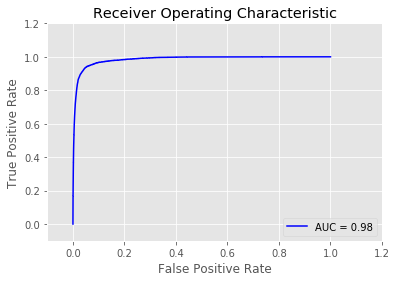

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.982002	valid's auc: 0.968885
[100]	train's auc: 0.984237	valid's auc: 0.970726
[150]	train's auc: 0.985175	valid's auc: 0.972598
[200]	train's auc: 0.98686	valid's auc: 0.974372
[250]	train's auc: 0.988044	valid's auc: 0.974886
[300]	train's auc: 0.989289	valid's auc: 0.976284
[350]	train's auc: 0.990051	valid's auc: 0.976551
[400]	train's auc: 0.990938	valid's auc: 0.977418
[450]	train's auc: 0.991722	valid's auc: 0.97754
[500]	train's auc: 0.99229	valid's auc: 0.978023
[550]	train's auc: 0.992797	valid's auc: 0.978369
[600]	train's auc: 0.993	valid's auc: 0.978633
[650]	train's auc: 0.993324	valid's auc: 0.978703
[700]	train's auc: 0.99362	valid's auc: 0.978913
[750]	train's auc: 0.993897	valid's auc: 0.978942
[800]	train's auc: 0.994124	valid's auc: 0.978767
[850]	train's auc: 0.994403	valid's auc: 0.978852
[900]	train's auc: 0.994662	valid's auc: 0.978939
[950]	train's 

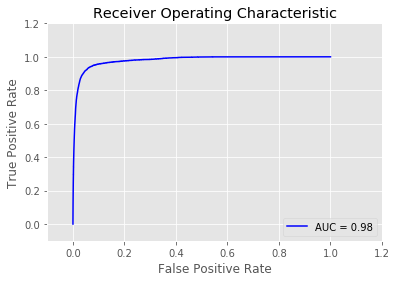

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.990718	valid's auc: 0.978337
[100]	train's auc: 0.992681	valid's auc: 0.980231
[150]	train's auc: 0.993022	valid's auc: 0.98083
[200]	train's auc: 0.993565	valid's auc: 0.981263
[250]	train's auc: 0.994189	valid's auc: 0.982536
[300]	train's auc: 0.994789	valid's auc: 0.983042
[350]	train's auc: 0.995144	valid's auc: 0.983474
[400]	train's auc: 0.995652	valid's auc: 0.983966
[450]	train's auc: 0.996139	valid's auc: 0.984537
[500]	train's auc: 0.996485	valid's auc: 0.984444
[550]	train's auc: 0.99677	valid's auc: 0.98478
[600]	train's auc: 0.996898	valid's auc: 0.984618
[650]	train's auc: 0.997134	valid's auc: 0.984698
[700]	train's auc: 0.997323	valid's auc: 0.984871
[750]	train's auc: 0.997507	valid's auc: 0.985092
[800]	train's auc: 0.997654	valid's auc: 0.984958
[850]	train's auc: 0.997861	valid's auc: 0.984818
[900]	train's auc: 0.998022	valid's auc: 0.984921
[950]	trai

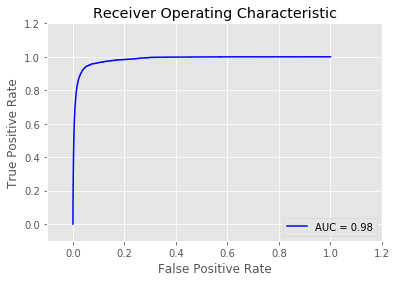

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.982084	valid's auc: 0.965385
[100]	train's auc: 0.984227	valid's auc: 0.968968
[150]	train's auc: 0.985114	valid's auc: 0.970722
[200]	train's auc: 0.986653	valid's auc: 0.971702
[250]	train's auc: 0.988034	valid's auc: 0.973288
[300]	train's auc: 0.98932	valid's auc: 0.974906
[350]	train's auc: 0.989999	valid's auc: 0.975661
[400]	train's auc: 0.990861	valid's auc: 0.976114
[450]	train's auc: 0.991643	valid's auc: 0.976961
[500]	train's auc: 0.992214	valid's auc: 0.977066
[550]	train's auc: 0.992699	valid's auc: 0.977328
[600]	train's auc: 0.992903	valid's auc: 0.977409
[650]	train's auc: 0.993239	valid's auc: 0.977636
[700]	train's auc: 0.993548	valid's auc: 0.977907
[750]	train's auc: 0.99381	valid's auc: 0.977826
[800]	train's auc: 0.994035	valid's auc: 0.9779
[850]	train's auc: 0.994346	valid's auc: 0.978232
[900]	train's auc: 0.994613	valid's auc: 0.978407
[950]	train

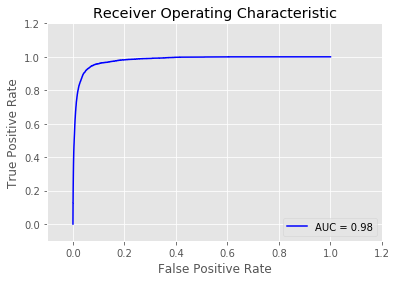

preparing validation datasets
Training until validation scores don't improve for 1000 rounds.
[50]	train's auc: 0.990759	valid's auc: 0.977356
[100]	train's auc: 0.992355	valid's auc: 0.979669
[150]	train's auc: 0.992916	valid's auc: 0.980293
[200]	train's auc: 0.993573	valid's auc: 0.980912
[250]	train's auc: 0.994176	valid's auc: 0.98172
[300]	train's auc: 0.994813	valid's auc: 0.982441
[350]	train's auc: 0.995147	valid's auc: 0.982667
[400]	train's auc: 0.995604	valid's auc: 0.983013
[450]	train's auc: 0.99609	valid's auc: 0.983756
[500]	train's auc: 0.996444	valid's auc: 0.98414
[550]	train's auc: 0.996744	valid's auc: 0.984353
[600]	train's auc: 0.99687	valid's auc: 0.984343
[650]	train's auc: 0.997073	valid's auc: 0.984278
[700]	train's auc: 0.99726	valid's auc: 0.98427
[750]	train's auc: 0.997439	valid's auc: 0.984336
[800]	train's auc: 0.997582	valid's auc: 0.984489
[850]	train's auc: 0.99777	valid's auc: 0.984617
[900]	train's auc: 0.997925	valid's auc: 0.984493
[950]	train's 

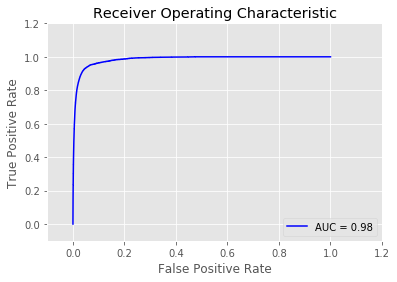

In [15]:
pos_model_list  =[]
neg_model_list  =[]
score_posA = []
score_negA = []

for idx in range(0,5):
    Train_DataSet = train_df[train_df.index.isin(list(all_list - DateFold[idx]))].reset_index(drop=True)
    Val_DataSet = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)
    model_pos,score_pos = model_validation(Train_DataSet,Val_DataSet,predictors,'Normal',{})
    model_neg,score_neg = model_validation(Train_DataSet,Val_DataSet,predictors,'Fraud',{})
    pos_model_list.append(model_pos)
    neg_model_list.append(model_neg)
    score_posA.append(score_pos)
    score_negA.append(score_neg)
    

In [16]:
import joblib
joblib.dump(pos_model_list,'./pos_model_list.dat')
joblib.dump(neg_model_list,'./neg_model_list.dat')
joblib.dump(score_pos,'./score_pos.dat')
joblib.dump(score_neg,'./score_neg.dat')

['./score_neg.dat']

In [24]:
val_df = train_df[train_df.index.isin(DateFold[5])].reset_index(drop=True)

val_r_pos=pd.DataFrame()
val_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(pos_model_list))):
    model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    val_pos = model_pos.predict(val_df[predictors],num_iteration=model_pos.best_iteration)
    val_neg = model_neg.predict(val_df[predictors],num_iteration=model_neg.best_iteration)
    val_r_pos[idx] = 1 - val_pos
    val_r_neg[idx] = val_neg

100%|██████████| 5/5 [01:53<00:00, 22.32s/it]


In [27]:
pos_mean = val_r_pos.mean(axis=1)
neg_mean = val_r_neg.mean(axis=1)

Ant-Score: 0.507537903053598


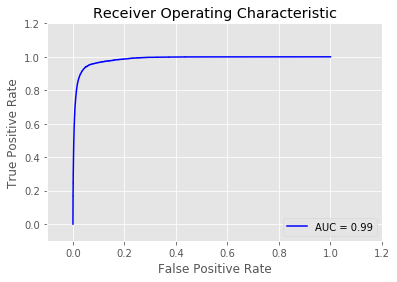

In [30]:
_,_,_ = atecml.data.accuracy_validation(val_df['Fraud'],neg_mean)

In [31]:
test_df = atecml.data.load_test()

In [33]:
test_r_pos=pd.DataFrame()
test_r_neg=pd.DataFrame()

for idx in tqdm(range(0,len(pos_model_list))):
    model_pos = pos_model_list[idx]
    model_neg = neg_model_list[idx]
    test_pos = model_pos.predict(test_df[predictors],num_iteration=model_pos.best_iteration)
    test_neg = model_neg.predict(test_df[predictors],num_iteration=model_neg.best_iteration)
    test_r_pos[idx] = 1 - test_pos
    test_r_neg[idx] = test_neg

100%|██████████| 5/5 [02:16<00:00, 26.80s/it]


In [34]:
neg_mean = test_r_neg.mean(axis=1)

In [35]:
result=pd.DataFrame()
result['id'] = test_df['id']
result['score'] = neg_mean

In [36]:
result[['id','score']].to_csv('./submit_2018_07_05_01.csv',index=False)

In [37]:
result

,id,score
0,661ae9a03c6c74feab2555c9987e140ae3f5421bd8e7a0...,0.046696
1,ada98d4358e72a27cc5e92f691a87a4fd62a7cda0387e2...,0.021905
2,e33675a962e5bf44d05a2b01903a4beb88a0c6385c05c6...,0.050160
3,4c5da176de7172dbd1ad0aa7edf9866548ec720d6c7318...,0.130002
4,fa39e3491900d49b862d30b5dbcd0b1c30bb4ff0d96396...,0.093155
5,ae0f1ecb27e098bbf672529a50237dff27abd16b349569...,0.022334
6,7a9e5e415412a92928f91608c39750e3a33eb123eb0ef8...,0.023695
7,51fb55256e959c36989151e8136a8a68002bb75887eb75...,0.064855
8,aa7664463d11ae5573ae6d89195373fbe033c354710142...,0.115058
9,b794af5790f98806ff8ad8ee268caa606dffcfbcb753bd...,0.096893
